# Customer Segmentation

In this notebook, we will perform the following tasks:
1. Create reports and store the data using Spark SQL
2. Data Visualization to gain insights from the datasurce
3. Bulid a Customer Segmentation Model

Prepare Spark SQL to Perform Queries

In [1]:
!pip install pyspark --quiet
!pip install -U -q PyDrive --quiet
!apt install openjdk-8-jdk-headless &> /dev/null

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 987.4/987.4 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("civComplaints") \
    .config("spark.ui.port", "4050") \
    .getOrCreate()

In [4]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip &> /dev/null
!unzip ngrok-stable-linux-amd64.zip &> /dev/null
get_ipython().system_raw('./ngrok http 4050 &')

Import the required libraries

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from math import pi
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

Load Data from Gdrive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load dataframe

In [7]:
df = pd.read_csv('/content/drive/My Drive/data test.csv', encoding='cp1252')

In [8]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


#DATA PREPOSESSING

### 1. Check Duplicate Data

In [9]:
duplicate_rows = df[df.duplicated(keep=False)]
duplicate_rows_sorted = duplicate_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description','InvoiceDate', 'CustomerID'])
duplicate_rows_sorted.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom


There are several rows containing duplicate data. It is necessary to clean these duplicates to avoid repeated calculations.Duplicate data may occur due to possible errors during data entry.

In [10]:
#Remove Duplicate Value
df = df.drop_duplicates()

In [11]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


### 2. Check if there are any quantity or price values that are less than 0 (i.e., negative values).

In [12]:
df_quantity_lower_0 = df[df['Quantity']<0].reset_index(drop=True)
df_quantity_lower_0.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
1,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
2,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
3,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
4,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom


In [13]:
df_unitprice_lower_0 = df[df['UnitPrice']<0].reset_index(drop=True)
df_unitprice_lower_0.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,A563186,B,Adjust bad debt,1,8/12/2011 14:51,-11062.06,NaN,United Kingdom
1,A563187,B,Adjust bad debt,1,8/12/2011 14:52,-11062.06,NaN,United Kingdom


In [14]:
df_lower_0 = df[(df['Quantity']<0)&(df['UnitPrice']<0)].reset_index(drop=True)
df_lower_0.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


Between the Quantity and UnitPrice columns, only one of them contains negative values.
This means that when used to calculate total sales, the result will be negative, which indicates a potential loss.


### 3. Check Null Value

In [15]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135037
Country,0


"Some rows have empty product descriptions. We need to verify if these products have corresponding price values."



### 4. Check price for null description

In [16]:
df[df['Description'].isnull()]['UnitPrice'].unique().tolist()

[0.0]

Products with null descriptions have a price of 0. This means that a discount was given by the company to the customer.

In [17]:
#Is there invoice number where customer do not have customerID
check_customerID = df[(df['CustomerID'].isna())]
check_customerID.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


For customers with a null CustomerID, this indicates an anomaly, as in most e-commerce businesses, customers are typically required to register an account before making a purchase. This issue might be due to a data recording error, where the customer information was not properly saved to the database.

In the context of monthly sales report visualizations, data from customers with null CustomerID values does not need to be removed.
However, when performing segmentation or recommendation analysis, these null records should be removed to avoid potential bias.

#Create reports using Spark SQL and store it

#1. Create a raw data for some monthly orders report and store the data using Spark SQL

In [18]:
#create temporary view from dataframe
spark_df_ = spark.createDataFrame(df)
spark_df_.createOrReplaceTempView('fact_orders_')

In [19]:
spark.sql('''
select InvoiceNo,
      StockCode,
      Description,
      Quantity,
coalesce(
		from_unixtime(unix_timestamp(InvoiceDate, 'M/d/yyyy H:mm'), 'yyyy-MM-dd HH:mm'),
    from_unixtime(unix_timestamp(InvoiceDate, 'M/d/yyyy HH:mm'), 'yyyy-MM-dd HH:mm'),
		from_unixtime(unix_timestamp(InvoiceDate, 'MM/dd/yyyy H:mm'), 'yyyy-MM-dd HH:mm'),
    from_unixtime(unix_timestamp(InvoiceDate, 'MM/dd/yyyy HH:mm'), 'yyyy-MM-dd HH:mm'),
		from_unixtime(unix_timestamp(InvoiceDate, 'M/dd/yyyy H:mm'), 'yyyy-MM-dd HH:mm'),
    from_unixtime(unix_timestamp(InvoiceDate, 'M/dd/yyyy HH:mm'), 'yyyy-MM-dd HH:mm'),
		from_unixtime(unix_timestamp(InvoiceDate, 'MM/d/yyyy H:mm'), 'yyyy-MM-dd HH:mm'),
    from_unixtime(unix_timestamp(InvoiceDate, 'MM/d/yyyy HH:mm'), 'yyyy-MM-dd HH:mm')
	) InvoiceDate,
      UnitPrice,
      CustomerID,
      Country
         from
fact_orders_
''').createOrReplaceTempView('fact_orders')

In [20]:
# Show fact_orders with sql
fact_orders = spark.sql('''
select * from
fact_orders
''').toPandas()

fact_orders table that store as temporary view will use as reference to create monthly orders report.

In [21]:
# Check data in fact_orders table
spark.sql('''
select * from
fact_orders
limit 5
''').toPandas()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26,3.39,17850.0,United Kingdom


# 2. Create monthly orders report by Country

In [22]:
report_monthly_orders_country_agg = spark.sql('''
  select last_day(InvoiceDate) invoice_month,
          Country,
          sum(Quantity) Quantity,
          sum(order) Orders
          from
(select to_date(InvoiceDate) InvoiceDate,
       Country,
       Quantity,
       Quantity*UnitPrice order
       from
fact_orders)
group by 1,2
order by 1,2''').toPandas()

In [23]:
report_monthly_orders_country_agg.sort_values(by=['Orders'], ascending=False).head(10)

,invoice_month,Country,Quantity,Orders
291,2011-11-30,United Kingdom,639256,1277409.790
268,2011-10-31,United Kingdom,454879,876246.450
241,2011-09-30,United Kingdom,457449,860104.362
23,2010-12-31,United Kingdom,296934,674615.860
143,2011-05-31,United Kingdom,305739,595250.390
193,2011-07-31,United Kingdom,322078,564406.021
95,2011-03-31,United Kingdom,279138,558458.890
169,2011-06-30,United Kingdom,257852,553330.210
218,2011-08-31,United Kingdom,319073,537870.900
122,2011-04-30,United Kingdom,256805,441414.761


# 3.Create monthly order report by product

In [24]:
report_monthly_orders_product_agg = spark.sql('''
  select last_day(InvoiceDate) invoice_month,
          Description,
          sum(Quantity) Quantity,
          sum(order) Orders
          from
(select to_date(InvoiceDate) InvoiceDate,
       Description,
       Quantity,
       Quantity*UnitPrice order
       from
fact_orders)
group by 1,2
order by 1,2''').toPandas()

In [ ]:
report_monthly_orders_product_agg.head(10)

,invoice_month,Description,Quantity,Orders,month
0,2010-12-31,4 PURPLE FLOCK DINNER CANDLES,16,45.82,2010-12
1,2010-12-31,OVAL WALL MIRROR DIAMANTE,22,283.03,2010-12
2,2010-12-31,SET 2 TEA TOWELS I LOVE LONDON,305,1003.99,2010-12
3,2010-12-31,*Boombox Ipod Classic,1,16.98,2010-12
4,2010-12-31,*USB Office Mirror Ball,2,16.94,2010-12
5,2010-12-31,10 COLOUR SPACEBOY PEN,565,509.97,2010-12
6,2010-12-31,12 COLOURED PARTY BALLOONS,62,40.93,2010-12
7,2010-12-31,12 DAISY PEGS IN WOOD BOX,12,23.22,2010-12
8,2010-12-31,12 EGG HOUSE PAINTED WOOD,11,254.91,2010-12
9,2010-12-31,12 IVORY ROSE PEG PLACE SETTINGS,22,28.76,2010-12


In [25]:
#Download csv data reports
from google.colab import files
fact_orders.to_csv('fact_orders.csv', index=False)
files.download('fact_orders.csv')
report_monthly_orders_country_agg.to_csv('report_monthly_orders_country_agg.csv', index=False)
files.download('report_monthly_orders_country_agg.csv')
report_monthly_orders_product_agg.to_csv('report_monthly_orders_product_agg.csv', index=False)
files.download('report_monthly_orders_product_agg.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 4. Data Visualization

### Monthly Orders Report by Country

In [26]:
report_monthly_orders_country_agg['invoice_month'] = pd.to_datetime(report_monthly_orders_country_agg['invoice_month'], utc=False)
report_monthly_orders_country_agg['month'] = report_monthly_orders_country_agg['invoice_month'].dt.to_period('M').astype(str)

# create list for legend
country = report_monthly_orders_country_agg['Country'].unique().tolist()

# create graph
fig = go.Figure()

for country in report_monthly_orders_country_agg['Country'].unique():
    country_data = report_monthly_orders_country_agg[report_monthly_orders_country_agg['Country'] == country]
    fig.add_trace(go.Scatter(
        x=country_data['month'],
        y=country_data['Orders'],
        mode='lines',
        name=f'{country}'
    ))

# Add title and axis label
fig.update_layout(
    title='Report Monthly Orders Country',
    xaxis_title='Month',
    yaxis_title='Order',
    xaxis_tickangle=-45,
    legend_title='Country'
)

# Show graph
fig.show()


It can be seen that the total monthly sales mostly occur in the United Kingdom while sales in other countries remain significantly lower.

The sales trend in the United Kingdom shows a generally positive movement each month. However, at the end of 2011, there was a noticeable decline in sales.Despite the drop, the United Kingdom still recorded the highest sales each month compared to other countries.

The significant gap in sales performance suggests that the company should consider focusing more on product sales in the United Kingdom rather than in other countries.

In [27]:
# Find the country with the most orders
total_orders_by_country = report_monthly_orders_country_agg.groupby('Country')['Orders'].sum().reset_index()
total_orders_by_country = total_orders_by_country.sort_values(by='Orders', ascending=False)

# Create graph
fig = go.Figure()

fig.add_trace(go.Bar(
    x=total_orders_by_country['Country'],
    y=total_orders_by_country['Orders'],
    text=total_orders_by_country['Orders'],
    textposition='outside',
    texttemplate='%{text:.2f}',
    name='Total Orders by Country'
))

# Add title and axis label
fig.update_layout(
    title='Total Order by Country',
    xaxis_title='Country',
    yaxis_title='Order',
    xaxis_tickangle=-45,
    yaxis=dict(
        title='Total Orders',
        titlefont=dict(
            color='royalblue'
        )
    ),
    bargap=0.2,
    width=3000,
    height=900
)

# show plot
fig.show()

orders_by_country = report_monthly_orders_country_agg.groupby('Country')['Orders'].sum()

# Calculate total quantity
total_orders = orders_by_country.sum()

# Calculate quantity percentage per Country
percentage_orders_by_country = (orders_by_country / total_orders) * 100

# Show the result
print(percentage_orders_by_country.sort_values(ascending=False))

Country
United Kingdom          83.972058
Netherlands              2.926808
EIRE                     2.704022
Germany                  2.277497
France                   2.028758
Australia                1.408695
Switzerland              0.579509
Spain                    0.562986
Belgium                  0.420635
Sweden                   0.376161
Japan                    0.363362
Norway                   0.361541
Portugal                 0.301285
Finland                  0.229557
Channel Islands          0.206420
Denmark                  0.192969
Italy                    0.173663
Cyprus                   0.132210
Austria                  0.104404
Hong Kong                0.101874
Singapore                0.093773
Israel                   0.081246
Poland                   0.074163
Unspecified              0.048745
Greece                   0.048432
Iceland                  0.044314
Canada                   0.037697
Malta                    0.025761
United Arab Emirates     0.019559
USA   

Approximately 84% of total sales are generated in the United Kingdom while sales from other countries contribute less than 3%.

This chart may serve as a strategic reference for the company to concentrate its sales efforts in the United Kingdom.

Doing so could help maximize revenue and reduce operational costs in regions with low sales performance.

In [28]:
report_monthly_orders_product_agg['invoice_month'] = pd.to_datetime(report_monthly_orders_product_agg['invoice_month'], utc=False)
report_monthly_orders_product_agg['month'] = report_monthly_orders_product_agg['invoice_month'].dt.to_period('M').astype(str)

#list legend
product = report_monthly_orders_product_agg['Description'].unique().tolist()

monthly_orders_by_product = report_monthly_orders_product_agg.groupby('Description')['Orders'].sum()

top_15_products = monthly_orders_by_product.nlargest(15).index

# Filter data fro 15 top products
filtered_data = report_monthly_orders_product_agg[report_monthly_orders_product_agg['Description'].isin(top_15_products)]

# Create a plot
fig = go.Figure()

# Add a line for each product in the plot
for product in filtered_data['Description'].unique():
    product_data = filtered_data[filtered_data['Description'] == product]
    fig.add_trace(go.Scatter(
        x=product_data['month'],
        y=product_data['Orders'],
        mode='lines',
        name=f'{product}'
    ))

# Add title and axis label
fig.update_layout(
    title='Top 15 Report Monthly Orders Product',
    xaxis_title='Month',
    yaxis_title='Order',
    xaxis_tickangle=-45,
    legend_title='Product'
)

# show a plot
fig.show()

The top 15 best-selling products are displayed in the chart.It can be observed that the sales distribution for each product is relatively consistent across months.

However, there is a significant increase in sales during November 2011 for these top 15 products.

This spike is likely due to customers preparing for Christmas celebrations at the end of the year, which typically leads to a noticeable rise in sales during that period.

In November 2011, tehre are 3 products with the most sales:
- DOTCOM POSTAGE
- RABBIT NIGHT LIGHT
- PAPER CHAIN KIT 50'S CHRISTMAS

For the RABBIT NIGHT LIGHT product, sales were initially not very high.
However, towards the end of the year sales increased significantly reaching their peak in November 2011.

#Gain Other Insights

### Estimate total loss

In [29]:
df_quantity_lower_0['order'] =  df_quantity_lower_0['Quantity']*df_quantity_lower_0['UnitPrice']
df_unitprice_lower_0['order'] = df_unitprice_lower_0['Quantity']*df_unitprice_lower_0['UnitPrice']

In [30]:
A = df_quantity_lower_0['order'].sum()
B = df_unitprice_lower_0['order'].sum()
print(A+B)

-916103.85


The company incurred sales losses of approximately $916,103.85 (assuming the currency is in dollars).
These losses may have been caused by damaged goods, incorrect orders, and other factors.

Check the data where product is null

In [31]:
df[df['Description'].isnull()]['UnitPrice'].unique().tolist()

[0.0]

In [32]:
df[df['Description'].isnull()]['Country'].unique().tolist()

['United Kingdom']

In [33]:
df[df['Description'].isnull()]['CustomerID'].unique().tolist()

[nan]

Products with a null description and a unit price of 0 generally occur due to discounts provided by the company to customers.

These null description products only appear in sales from the United Kingdom, which is the country with the highest total sales.

However, there is an anomaly where products with a null description and a price of 0 do not have a missing CustomerID which is unexpected as such entries are often associated with incomplete or test data.

##Customer Segmentation Modeling

### Data Processing (Remove null value)

In [34]:
#Drop null value
df = df.dropna(subset=['CustomerID', 'Description'])

In [35]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [36]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


## Drop Negative Value (Quantity dan UnitPrice)

In [37]:
df = df[df['UnitPrice'] > 0].reset_index(drop=True)

In [38]:
df = df[df['Quantity'] > 0].reset_index(drop=True)

In [39]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


## Feature Engineering (Feature RFM)

- Recency (R): mengukur seberapa baru pelanggan melakukan pembelian.
- Frequency (F): mengukur seberapa sering pelanggan melakukan pembelian dalam periode waktu tertentu.
- Monetary (M) : mengukur total nilai uang yang dibelanjakan oleh pelanggan selama periode waktu tertentu.

In [40]:
#Calculate Recency
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceDay'] = df['InvoiceDate'].dt.date

df_customer = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()
recent_date = df['InvoiceDay'].max()
df_customer['InvoiceDay'] = pd.to_datetime(df_customer['InvoiceDay'])
recent_date = pd.to_datetime(recent_date)

df_customer['Recency'] = (recent_date - df_customer['InvoiceDay']).dt.days

# Drop InvoiceDay feature in dataframe
df_customer.drop(columns=['InvoiceDay'], inplace=True)

In [41]:
df_customer.head()

,CustomerID,Recency
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


In [42]:
#Calculate Frequency
total_sales = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_sales.rename(columns={'InvoiceNo': 'Frequency'}, inplace=True)

total_products_ordered = df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_ordered.rename(columns={'Quantity': 'Total_Products_Ordered'}, inplace=True)

#Merge new feature baru into df_customer table
df_customer = pd.merge(df_customer, total_sales, on='CustomerID')
df_customer = pd.merge(df_customer, total_products_ordered, on='CustomerID')
df_customer.head()

,CustomerID,Recency,Frequency,Total_Products_Ordered
0,12346.0,325,1,74215
1,12347.0,2,7,2458
2,12348.0,75,4,2341
3,12349.0,18,1,631
4,12350.0,310,1,197


In [43]:
#Calculate Monetary
df['Monetary'] = df['Quantity'] * df['UnitPrice']
total_spend = df.groupby('CustomerID')['Monetary'].sum().reset_index()

df_customer = pd.merge(df_customer, total_spend, on='CustomerID')
df_customer.head()

,CustomerID,Recency,Frequency,Total_Products_Ordered,Monetary
0,12346.0,325,1,74215,77183.60
1,12347.0,2,7,2458,4310.00
2,12348.0,75,4,2341,1797.24
3,12349.0,18,1,631,1757.55
4,12350.0,310,1,197,334.40


Karena mayoritas penjualan berasal dari United Kingdom, kita dapat menambahkan variable untuk mengecek apakah berasal dari United Kingdom atau bukan

In [44]:
#Calculate Total unique products ordered
unique_products_ordered = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_ordered.rename(columns={'StockCode': 'Unique_Products_Ordered'}, inplace=True)

df_customer = pd.merge(df_customer, unique_products_ordered, on='CustomerID')

df_customer.head()

,CustomerID,Recency,Frequency,Total_Products_Ordered,Monetary,Unique_Products_Ordered
0,12346.0,325,1,74215,77183.60,1
1,12347.0,2,7,2458,4310.00,103
2,12348.0,75,4,2341,1797.24,22
3,12349.0,18,1,631,1757.55,73
4,12350.0,310,1,197,334.40,17


Check Customer Behavior (Customer Activity)

In [45]:
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek
df['Day'] = df['InvoiceDate'].dt.day
df['Hour'] = df['InvoiceDate'].dt.hour

In [46]:
favorite_day = df.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_day = favorite_day.loc[favorite_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

favorite_date = df.groupby(['CustomerID', 'Day']).size().reset_index(name='Count')
favorite_date = favorite_date.loc[favorite_date.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day']]

favorite_hour = df.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_hour = favorite_hour.loc[favorite_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

df_customer = pd.merge(df_customer, favorite_day, on='CustomerID')
df_customer = pd.merge(df_customer, favorite_date, on='CustomerID')
df_customer = pd.merge(df_customer, favorite_hour, on='CustomerID')

df_customer.head()

,CustomerID,Recency,Frequency,Total_Products_Ordered,Monetary,Unique_Products_Ordered,Day_Of_Week,Day,Hour
0,12346.0,325,1,74215,77183.60,1,1,18,10
1,12347.0,2,7,2458,4310.00,103,1,7,14
2,12348.0,75,4,2341,1797.24,22,3,16,19
3,12349.0,18,1,631,1757.55,73,0,21,9
4,12350.0,310,1,197,334.40,17,2,2,16


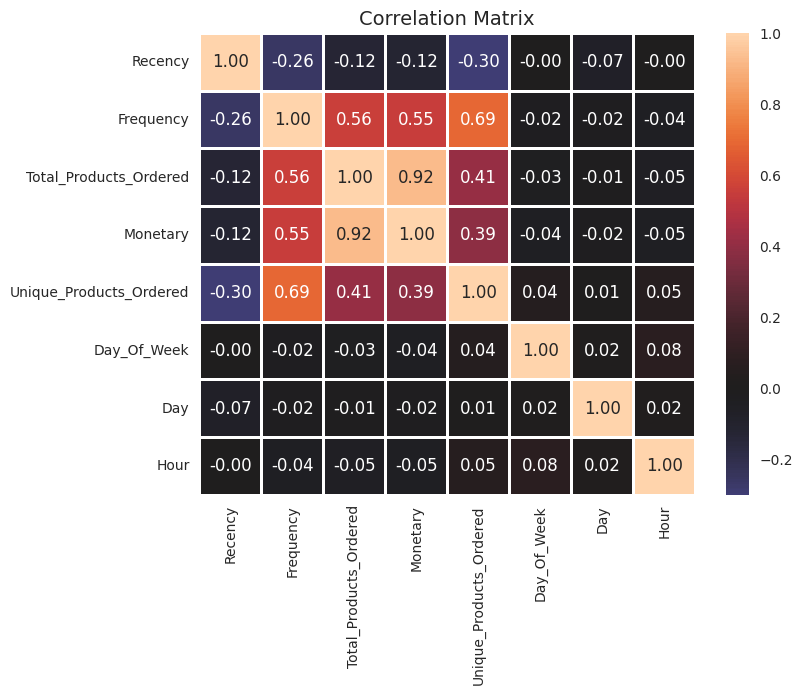

In [47]:
#Check Correlation
sns.set_style('whitegrid')

corr = df_customer.drop(columns=['CustomerID']).corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr,annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

There are several features with correlation values close to 1, including:

- Total_Products_Ordered and Monetary
- Frequency and Unique_Products_Ordered
- Frequency and Total_Products_Ordered, among others

These features could serve as important factors in determining customer segmentation later on.

Feature Standardization

In [48]:
scaler = StandardScaler()

# features do not need scalling process
feature_to_exclude = ['CustomerID','Day_Of_Week']

# features need scalling process
feature_to_scale = df_customer.columns.difference(feature_to_exclude)

customer_data_scaled = df_customer.copy()

# data scalling
customer_data_scaled[feature_to_scale] = scaler.fit_transform(customer_data_scaled[feature_to_scale])

customer_data_scaled.head()

,CustomerID,Recency,Frequency,Total_Products_Ordered,Monetary,Unique_Products_Ordered,Day_Of_Week,Day,Hour
0,12346.0,2.329388,-0.425097,14.480825,8.363010,-0.708802,1,0.372361,-1.074814
1,12347.0,-0.900588,0.354417,0.251903,0.251699,0.486180,1,-0.899076,0.650456
2,12348.0,-0.170593,-0.035340,0.228702,-0.027988,-0.462776,3,0.141191,2.807044
3,12349.0,-0.740589,-0.425097,-0.110379,-0.032406,0.134715,0,0.719117,-1.506131
4,12350.0,2.179389,-0.425097,-0.196438,-0.190812,-0.521354,2,-1.477002,1.513091


PCA (Principal Component Analysis) is a dimensionality reduction technique used to simplify large datasets by transforming them into fewer variables called principal components while retaining most of the important information.

In [49]:
# Check optimal K in PCA
customer_data_scaled.set_index('CustomerID', inplace=True)

pca = PCA().fit(customer_data_scaled)

# Compute the cumulative variance to identify the optimal value of K in PCA.
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

In [50]:
cumulative_explained_variance

array([0.32888546, 0.60298062, 0.71157272, 0.80653944, 0.89910323,
       0.96591379, 0.99264699, 1.        ])

We can use k=4 where variance threshold around 80% n PCA

In [51]:
#PCA
pca = PCA(n_components=4)

customer_data_pca = pca.fit_transform(customer_data_scaled)

# Convert PCA result into DataFrame
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PCA'+str(i+1) for i in range(pca.n_components_)])

# Add CustomerID into PCA data as index
customer_data_pca.index = customer_data_scaled.index

In [52]:
customer_data_pca

,PCA1,PCA2,PCA3,PCA4
CustomerID,,,,
12346.0,-3.044884,10.405413,8.799208,-1.873278
12347.0,-1.570555,0.666744,-0.497352,1.080360
12348.0,0.612302,-0.082822,-0.902915,1.957360
12349.0,-2.584039,-0.298396,-0.432708,-1.562626
12350.0,-0.392348,-1.165038,1.553781,2.243070
...,...,...,...,...
18280.0,-2.550998,-1.307106,2.033577,-0.385708
18281.0,3.425578,-0.536599,1.347902,-0.766443
18282.0,1.479453,-0.295470,0.059571,0.639042


#Data Modeling

Evaluation to Determine the Optimal Number of Clusters (K) in the Customer Clustering/Segmentation Process

The value of K will determine how many clusters are formed in the analysis.
There are several common methods used to determine the optimal number of clusters:

- Elbow Method
- Silhouette Score
- Davies-Bouldin Index


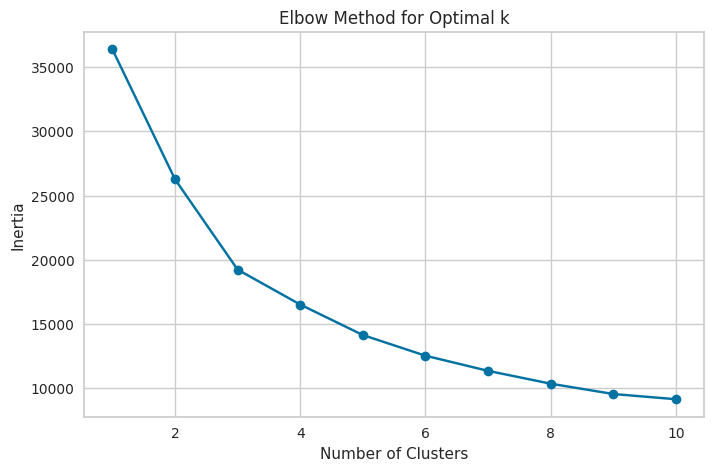

In [53]:
inertia = []
k_values = range(1, 11)  #1-10 cluster
X = customer_data_pca

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


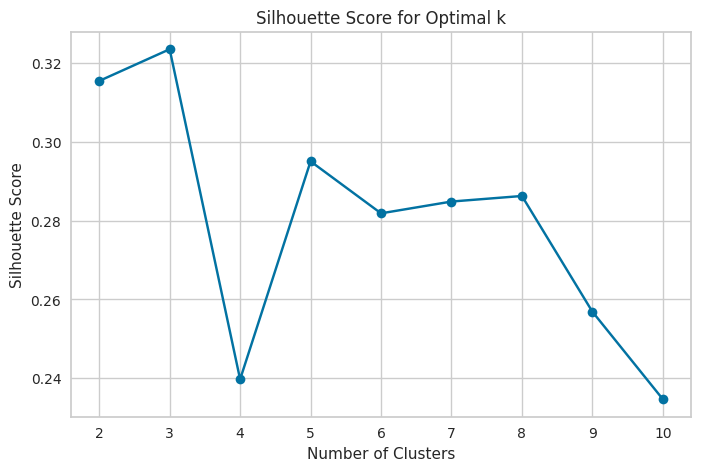

In [54]:
# Store silhouette score for each k into a list
silhouette_scores = []

k_values = np.arange(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(customer_data_pca)
    silhouette_avg = silhouette_score(customer_data_pca, clusters)
    silhouette_scores.append(silhouette_avg)

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.grid(True)
plt.show()

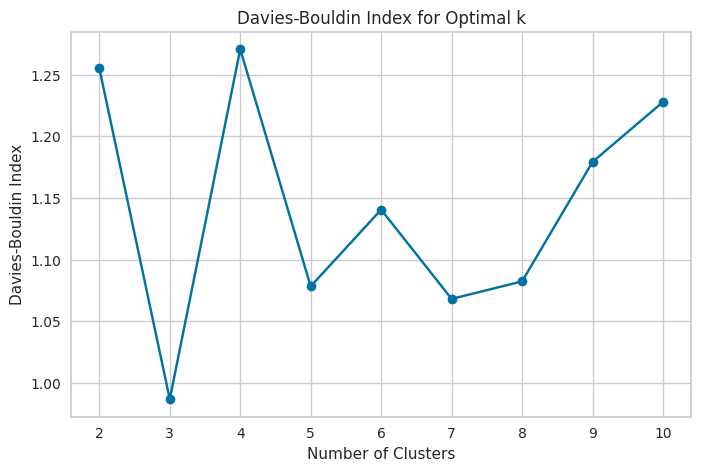

In [55]:
# Store Davies-Bouldin Index for each k
dbi_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(customer_data_pca)
    dbi_score = davies_bouldin_score(customer_data_pca, clusters)
    dbi_scores.append(dbi_score)

# Plot Davies-Bouldin Index
plt.figure(figsize=(8, 5))
plt.plot(k_values, dbi_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index for Optimal k')
plt.grid(True)
plt.show()

Conclusion Based on Optimal K Evaluation for KMeans Clustering:

- From the Elbow Method, the curve begins to flatten at k = 4.
- The Silhouette Score reaches its highest value at k = 3.
- The Davies-Bouldin Index achieves its lowest score at k = 3.

Although the Elbow Method suggests a possible value at k=4, the other two evaluation metrics (Silhouette Score and Davies-Bouldin Index) strongly support k=3 making it the more reliable choice.

Based on these results, we will use k = 3 as the optimal number of clusters for the KMeans clustering process.

In [56]:
# Perform KMeans clustering using optimum k
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca)

cluster_frequencies = Counter(kmeans.labels_)

label_mapping = {label: new_label for new_label, (label, _) in
                 enumerate(cluster_frequencies.most_common())}

# map clustering label
label_mapping = {v: k for k, v in {1: 0, 2: 1, 3: 2}.items()}

new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

df_customer['cluster'] = new_labels

customer_data_pca['cluster'] = new_labels

In [57]:
df_customer.head()

,CustomerID,Recency,Frequency,Total_Products_Ordered,Monetary,Unique_Products_Ordered,Day_Of_Week,Day,Hour,cluster
0,12346.0,325,1,74215,77183.60,1,1,18,10,3
1,12347.0,2,7,2458,4310.00,103,1,7,14,2
2,12348.0,75,4,2341,1797.24,22,3,16,19,1
3,12349.0,18,1,631,1757.55,73,0,21,9,2
4,12350.0,310,1,197,334.40,17,2,2,16,2


Metrics Evaluation

In [58]:
# Count total customer
num_observations = len(customer_data_pca)

# Split cluster label in the dataframe to check model evaluation
X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']

# Calculate metrics
sil_score = silhouette_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

evaluation_Score = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Davies Bouldin Score", davies_score]
]

df_evaluation = pd.DataFrame(evaluation_Score, columns=['Metric', 'Value'])
df_evaluation

,Metric,Value
0,Number of Observations,4338.000000
1,Silhouette Score,0.323328
2,Davies Bouldin Score,0.984319


Evaluation of Clustering Metrics

The Silhouette Score is approximately 0.32 which indicates a moderately good result in forming customer segments for each cluster. There may be some overlap between clusters due to similarities in certain customer characteristics.
Ideally, a Silhouette Score closer to 1 indicates well-separated and well-defined clusters.

The Davies-Bouldin Score is around 0.98 which is considered fairly good in terms of customer segmentation.However, some overlap may still exist between clusters with similar traits. A lower Davies-Bouldin Score (closer to 0) generally reflects better cluster separation.

Based on the evaluation metrics above, the model can still be improved to create clusters that are more distinctly separated.
This can be done, for example by experimenting with different clustering parameters or algorithms.


#Create the Radar Chart untuk know type for each cluster in Customer Segmentation

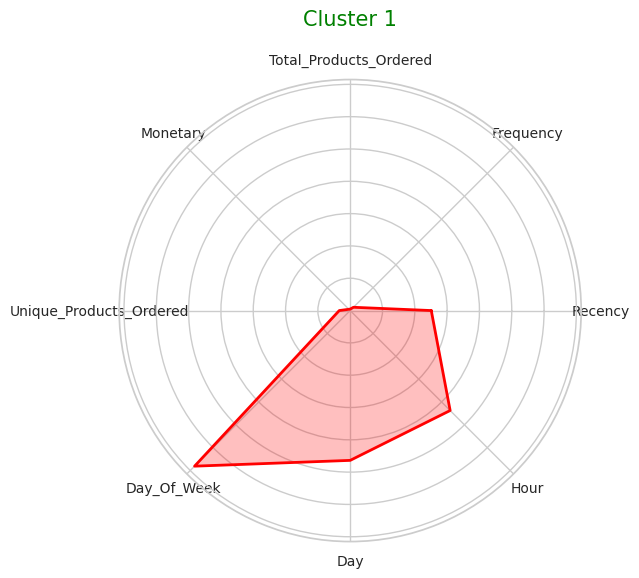

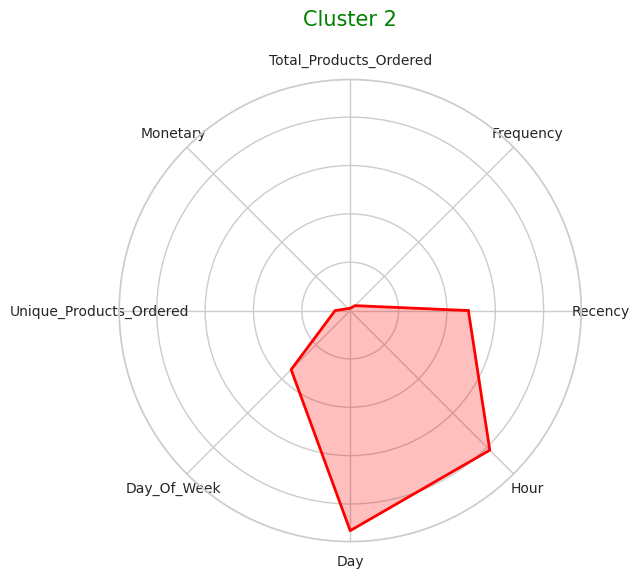

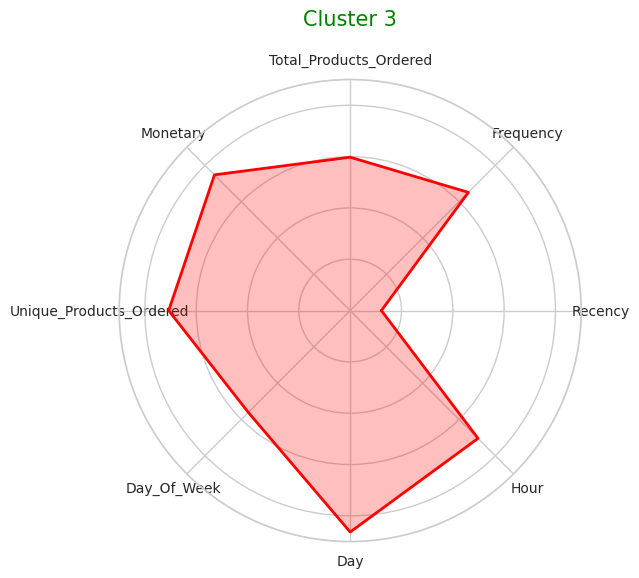

In [59]:
from math import pi

# 1. Data Preparation
features_to_plot = ['Recency', 'Frequency', 'Total_Products_Ordered', 'Monetary', 'Unique_Products_Ordered', 'Day_Of_Week', 'Day', 'Hour']
clusters = df_customer['cluster'].unique()

# 2. Data Normalization
df_customer_normalized = df_customer.copy()
for feature in features_to_plot:
    min_val = df_customer_normalized[feature].min()
    max_val = df_customer_normalized[feature].max()
    if max_val != min_val:
        df_customer_normalized[feature] = (df_customer_normalized[feature] - min_val) / (max_val - min_val)
    else:
        df_customer_normalized[feature] = 0

# 3. Data aggregation by cluster
cluster_summary = df_customer_normalized.groupby('cluster')[features_to_plot].mean().reset_index()

# 4. Create Radar Chart
def radar_chart(data, labels, title):
    num_vars = len(labels)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    data = np.concatenate((data, [data[0]]))
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))
    ax.fill(angles, data, color='red', alpha=0.25)
    ax.plot(angles, data, color='red', linewidth=2)

    # Labels
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)

    plt.title(title, size=15, color='green', y=1.1)
    plt.show()

# Plot radar chart
for i, cluster in cluster_summary.iterrows():
    cluster_data = cluster[features_to_plot].values
    radar_chart(cluster_data, features_to_plot, f'Cluster {int(cluster["cluster"])}')

Customer segmentation based on the radar chart above can be categorized as follows:

Cluster 1:
- Customers have made purchases quite recently.
- They are more active during weekends.
- Most of their activity occurs during the afternoon hours.
- They tend to shop during the beginning to the middle of the month.
- Both the number of products purchased and total spending are very low.

🟠 Strategy:
This segment should be targeted with special offers, such as membership programs or discounts, to encourage continued shopping behavior.
Additionally, recommend alternative products to broaden their shopping interest.
Send notifications or promotions that align with the customer's active time preferences.

Cluster 2:
- These customers have not made purchases for quite a while.
- They are more active during weekdays.
- Most of their activity occurs in the late afternoon to evening.
- They tend to shop at the end of the month.
- Product variety and total spending are very low.

🔵 Strategy:
This segment is not a priority at the moment. Start by sending reminder notifications or product suggestions to re-engage them as they have been inactive for some time. If they begin to respond and make purchases again, follow up with personalized offers to sustain the engagement.

Cluster 3:
- These customers are very active shoppers.
- They have very high total spending.
- They purchase a wide variety of products.
- Most active during weekdays, especially in the afternoon to early evening.
- They tend to shop at the end of the month.

 🟢 Strategy:
This is a high-priority segment due to their frequent purchases and high spending. Reward them with premium membership status and exclusive benefits, such as discounts, loyalty points or other incentives. These strategies can serve as appreciation and motivation to retain these valuable customers.